In [ ]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
!pip install control
from control import *
sp.init_printing()

digital - 28.svg

---



### Respostas:

**Item (a)** - A conversão deve ser feita no sistema de **malha aberta**. Para isso podemos usar qualquer um dos métodos desenvolvidos até agora: Tustin (bilinear, ou trapezoidal), mapeamento ou ZOH. Neste caso, optamos por usar Tustin, onde basta fazer a substituição:

\begin{align}
s = \frac{2}{T}\,\frac{z-1}{z+1}
\end{align}

Vamos resolver usando o SymPy, ao invés de usar as bibliotecas de controle do SciPy. Começamos definido os símbolos do problema

In [ ]:
z = sp.symbols('z')
s = sp.symbols('s')
K = sp.symbols('K', real=True,positive=True)
T = 0.1

Agora definimos a função de transferência do problema e fazemos logo a substituição de Tustin.

In [ ]:
G = K/(s*(s**2+7*s+1220))
Gz = G.subs(s,(2/T)*(z-1)/(z+1))
Gz

K*(z + 1)/((20.0*z - 20.0)*(400.0*(z - 1)**2/(z + 1)**2 + 1220 + 7*(20.0*z - 20.0)/(z + 1)))

Observe que a mera substituição não apresenta o resultado do jeito convencional. Para isso o método factor() foi encontrado como o mais adequado (mas pode nem sempre ser o caso!). Eu também encorajo vc a tentar fazer essas contas na mão, ao menos uma vez na vida ;)



In [ ]:
Gz.factor()

2.84090909090909e-5*K*(z + 1)**3/((z - 1)*(1.0*z**2 + 0.931818181818182*z + 0.840909090909091))

Para todos os efeitos, vamos arredondar a função para:
\begin{align}
  \hat{G}(z) &= \frac{2.841\cdot 10^{-5}K(z+1)^3}{(z-1)(z^2+0.932z+0.841)}
\end{align}

**Item (b)**  - O item pede que façamos um esboço do LGR. Neste caso do equivalente discreto que acabamos de calcular. Temos uma função da biblioteca *control* que faz isso, mas vale a pena lembrar algumas coisas sobre LGR.


1.   LGR é uma figura que mostra todas as raízes de **malha fechada**, conhecido o sistema em **malha aberta**. 
2.   As raízes de malha fechada mudam porque supomos que o sistema está sujeito a controle proporcional, o ganho variando de zero ao infinito
3.   Regras do LGR para sistemas discretos são as mesmas de sistemas contínuos
3.   O LGR começa sempre nos pólos de malha aberta
4.   O LGR termina sempre nos zeros ou nas assíntotas (assíntotas as vezes podem ser consideradas zeros no infinito)
5.   Número de assíntotas = (Número de Polos) - (Número de zeros)
6.   Regra do eixo real: LGR existe em cima do eixo real em qualquer trecho para o qual há um número ímpar de pólos+zeros à direita






O sistema calculado possui, em malha aberta:


*   Um zero **triplo** em $-1$
*   Um integrador $z=1$
*   Um par de conjugados dados pelo polinômio (coeficientes foram arredondados):
\begin{align}
  z^2-0.932z+0.841
\end{align}

As raízes foram calculadas usando a função roots()

In [ ]:
np.roots([1,0.932,0.841])

array([-0.466+0.78983796j, -0.466-0.78983796j])

Vamos plotar o LGR usando a função rlocus(), mas antes, analisamos algumas coisas que podemos esperar desse sistema.

1o: Ele não vai ter assíntotas, pois o número de polos é igual ao de zeros.

2o: Usando a regra do eixo real, vemos que ele vai ter apenas um trecho em cima do eixo real, ligando o pólo em $z=1$ ao zero em $z=-1$.

3o: O mais provável é que polos se desloquem direto do par conjugado para os outros zeros em $-1$. 

4o: Dado que o sistema analógico possui apenas 3 polos (LGR hiperbólico), podemos esperar um limite de ganho $K$ de estabilidade, isto é, acima de um determinado valor, o sistema fica **instável**.

Abaixo temos o código definindo o numerador, o denominador (produto de dois polinômios) e a função de transferência. Repare como usamos a função rlocus() para calcular as raízes, os ganhos e plotar o gráfico. Diferente do MATLAB esse gráfico não é interativo!

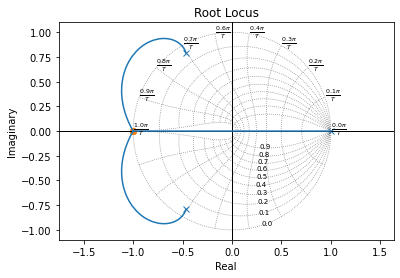

In [ ]:
num = 2.841e-5*np.array([1,3,3,1])
den = np.convolve([1,-1],[1,0.932,0.841])
sys = TransferFunction(num,den,T)
r,k=rlocus(sys,plot=True)

**Item (c)**  - Esse item é um pouco complicado de fazer na mão, mas é possível. Mas antes disso, vamos lembrar uma coisa.

Primeiro: problemas para achar uma faixa ou intervalo de ganho para estabilidade normalmente é resolvido usando o critério de Routh-Hurwitz. Esse é um critério que se aplica bem para sistema contínuos (onde o objetivo é determinar o número de raízes no plano direito). 

Porém, no plano Z a estabilidade é o interior do círculo unitário, então o critério não pode ser diretamente aplicado. Existe uma versão (chamada de critério de [Jury](https://en.wikipedia.org/wiki/Jury_stability_criterion)) para achar o número de raízes dentro ou fora do círculo unitário, mas ela é relativamente complicada. Fica o link para sua referência futura.

Para analisar intervalos de estabilidade para uma função de transferência discreta, podemos usar 2 formas mais simples. 

1 - Use a transformação de Tustin inversa
\begin{align}
  z = \frac{2+Ts}{2-Ts}
\end{align}
e aplique o critério de Routh no polinômio resultante.

2 - Dependendo do sistema, podemos colocar as raízes em cima do círculo e resolver a equação para ganho e frequência (tal como se faz no contínuo, impondo $s=j\omega$). Achamos o valor crítico de ganho, **normalmente** (mas não sempre), acima do qual o sistema instabiliza. Mas para afirmar isso com certeza, precisamos conhecer o LGR do sistema. Neste caso nós conhecemos e sabemos que existe um valor de ganho além do qual as raízes saem do círculo!

Vamos resolver usando os dois métodos. Antes de tudo, vamos achar o polinômio de malha fechada (MF):


In [ ]:
mf=sp.collect(sp.numer((1+Gz).simplify()),z)
mf

Note que usamos $1+\hat{G}(z)$. Lembre que o ganho $K$ já está embutido na variável. Note também que usamos as funções:


*   simplify() para fazer a conta $1+\hat{G}(z)$, numerador e denominador
*   numer() para extrair o numerador do resultado (é o que nos dá as raízes de MF)
*   collect() em relação a $z$ para organizar como polinômio de $z$. 

Note que o resultado é de terceira ordem para qualquer valor de $K$. **O ganho não altera a ordem do sistema em MF**. 

**Método 1:** Neste caso, como o nosso equivalente discreto foi calculado usando Tustin em cima do analógico, se aplicarmos a transmada inversa, vamos voltar (em tese) para a planta original do problema. 
\begin{align}
G(s) &= \frac{K}{s(s^2+7s+1220)}
\end{align}

Isso não seria verdade se tivéssemos calculado usando outro método de discretização. Além disso, só conseguimos voltar exatamente se usarmos a função $\hat{G}(z)$ exata, **antes** dos arredondamentos. Supondo que façamos isso, para simplificar os cálculos, então temos apenas que aplicar o critério de Routh no polinômio de malha fechada analógico, que vai ser o numerador de $1+KG(s)$, isto é:
\begin{align}
s^3+7s^2+1220s+K
\end{align}

Aplicando a tabela de Routh:
\begin{array}{c|cc}
s^3 & 1 & 1220\\
s^2 & 7 & K\\
s^1 & a & 0\\
s^0 & b
\end{array}

Para quem não lembra, eis como calcular os valores desconhecidos da tabela:
\begin{align}
  a &= \frac{1220\cdot 7-K\cdot 1}{7} = 1220-\frac{K}{7}\\
  b & = \frac{K\cdot a-7\cdot 0}{a} = K
\end{align}

Para termos todas as raízes no semi-plano esquerdo, não pode haver mudança de sinal na primeira coluna. Alguns elementos já são positivos, então devemos ter $a>0$ e $b>0$. Resolvendo as desigualdades temos:
\begin{align}
  0< K < 1220\cdot 7 
\end{align}

Ou seja, $K<8540$ é o nosso limite de ganho

**Método 2**: nesse método impomos as raízes em cima do círculo unitário e resolvemos para a frequência e o ganho. 

Vc deve lembrar desse método em Controle I, onde fazemos $s=j\omega$. No plano Z, fazemos $z=e^{j\omega}$. Devemos fazer essa substituição na equação de malha fechada "mf". Depois temos que separar as partes real e imaginária e igualar tudo a zero para poder resolver para $K$ e $\omega$. 

Isso dá um pouco de trabalho de fazer na mão, porque precisamos substituir
\begin{align}
  e^{j\omega} = \cos(\omega) + j \sin(\omega)
\end{align}

Mas felizmente, definimos $K$ e vamos definir agora $\omega$ como variáveis reais, de modo que podemos gerar e resolver facilmente as equações como SymPy.

In [ ]:
w = sp.symbols('w',real=True)
eq=mf.subs(z,sp.cos(w)+1j*sp.sin(w))
eq

Precisamos expandir e separar em partes real e imaginária, gerando duas equações. Isso dá um trabalhão, mas felizmente há funções no SymPy que fazem isso bem fácil. 

Para a parte real:

In [ ]:
eq1 = sp.re(eq)
eq1

Agora para a parte imaginária:

In [ ]:
eq2 = sp.im(eq)
eq2

Lembre-se que ele só conseguiu separar fácil assim porque definimos lá em cima $K$ como real (e positivo) e $w$ como real. Basta agora resolver o sistema usando a função solve(). Repare que precisamos juntar as duas equações.

In [ ]:
sol = sp.solve([eq1,eq2])
sol

Note que a solução nos dá um ganho crítico de 8540 também, o mesmo valor encontrado na análise do contínuo. 

### Isto conclui o exercício. Eu recomendo fortemente que você leia com atenção todos os passos novamente e confira os cálculos mais simples **manualmente**. Revise todas as funções utilizadas: elas podem ser úteis em outros exercícios. 

### Como desafio final, tente plotar o LGR do sistema analógico e analise se os resultados estão coerentes com o que resolvemos até aqui.

(-1.0, 1.0)

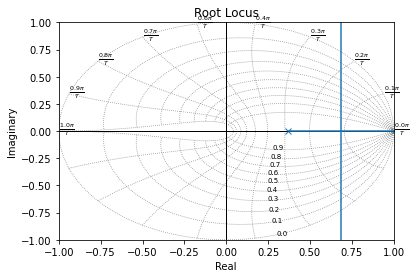

In [ ]:
num = 126.4
den = np.convolve([1,-1],[1,-0.368])
sys = TransferFunction(num,den,0.01)
r,k=rlocus(sys,xlim=(-1,1),ylim=(-1,1))
plt.gca().axis('auto')
plt.xlim([-1,1])
plt.ylim([-1,1])


In [ ]:
k[abs(np.imag(r[:,0])-0.3)<0.05]

array([0.00137041, 0.00164449])